In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import sys
import csv
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.io as sio
import ipyvolume as ipv
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from os.path import dirname, join as pjoin
from PIL import Image
from scipy.io import savemat

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Pre-Processing

In [15]:
transform=transforms.Compose([
                            transforms.Resize((127,127)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
                               ])

In [16]:
class ShapeNetDataset(Dataset):
    def __init__(self, img_dir, voxel_dir=None, transform=None, min_idx=0, max_idx=20000):
        self.img_dir = img_dir
        self.voxel_dir = voxel_dir
        self.transform = transform
        self.img_paths = []
        self.voxel_paths = []
        for folder in os.listdir(self.img_dir):
            folder_path = os.path.join(self.img_dir, folder)
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                voxel_path = os.path.join(self.voxel_dir, folder, 'model.mat')
                self.img_paths.append(image_path)
                self.voxel_paths.append(voxel_path)
        self.img_paths = self.img_paths[min_idx: max_idx] 
        self.voxel_paths = self.voxel_paths[min_idx: max_idx]
        
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        voxel_shape = (32, 32, 32) 
        voxel = torch.zeros(voxel_shape, dtype=torch.float)
        voxel_path = self.voxel_paths[idx]
        if self.voxel_dir:
            if os.path.exists(voxel_path): 
                voxel_data = sio.loadmat(voxel_path)
                voxel = torch.from_numpy(voxel_data['input']).float()
                voxel_tensor = F.adaptive_max_pool3d(voxel, output_size=(32, 32, 32))
        return image, voxel_tensor

In [17]:
train_dataset = ShapeNetDataset(img_dir='./ShapeNet/train_imgs', voxel_dir='./ShapeNet/train_voxels', transform=transform, min_idx=0, max_idx=20000)
valid_dataset = ShapeNetDataset(img_dir='./ShapeNet/val_imgs', voxel_dir='./ShapeNet/val_voxels', transform=transform, min_idx=20001, max_idx=24001)

batch_size = 8
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [18]:
print(len(train_dataset))
print(len(valid_dataset))

20000
4000


In [19]:
class ShapeNetTestDataset(Dataset):
    def __init__(self, img_dir, transform=None, min_idx = 0, max_idx = 100):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = [os.path.join(root, name)
                          for root, dirs, files in os.walk(img_dir)
                          for name in files if name.endswith((".png", ".jpg"))]
        self.img_paths = self.img_paths[min_idx:max_idx]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, os.path.basename(img_path)  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


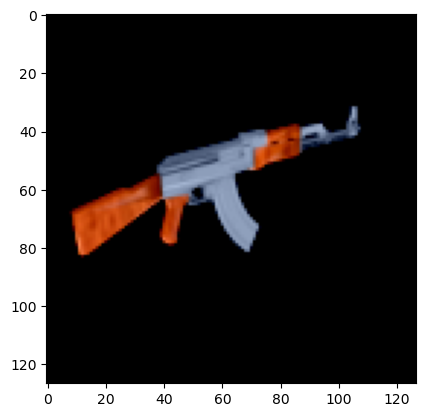

('009.png',)


In [53]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

torch.set_printoptions(threshold=5000)
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_colwidth',1000)

def imshow(img,filename):
    img = img/ 2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    print(filename)

dataiter = iter(test_loader)
images, filename = next(dataiter)

imshow(torchvision.utils.make_grid(images), filename)

3D-R2N2 Neural Network

In [4]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2)
        )
    def forward(self, x):
        x = self.layers(x)
        
        x = torch.flatten(x, start_dim=1)
        
        return x

In [5]:
class GRU(nn.Module):
    def __init__(self):
        super(GRU, self).__init__()
        self.gru = nn.GRU(9216, 128, num_layers=1, batch_first=True, dropout=0.5)
        self.fc1 = nn.Linear(128, 1024)
        
    def forward(self, x):
        x, _ = self.gru(x)
        x = self.fc1(x)
        return x

In [6]:
class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()
        self.conv = nn.Conv3d(128, 1, kernel_size=(3, 3, 3), stride=1, padding=1)
        # self.relu = nn.LeakyReLU(0.1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = x.view(x.shape[0],128,2,2,2)
        x = nn.functional.interpolate(x, size=(32, 32, 32), mode='trilinear')
        x = self.conv(x)
        # x = self.relu(x)
        x = self.sigmoid(x)
        return x

In [7]:
from torch.utils.tensorboard import SummaryWriter

# Initialize the TensorBoard writer
writer = SummaryWriter('runs/3d_reconstruction_experiment')

2024-04-29 11:26:07.381607: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 11:26:07.381720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 11:26:07.451297: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-29 11:26:07.599148: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 11:26:09.681613: W tensorflow/compiler/tf2

In [8]:
import matplotlib.pyplot as plt

def visualize_slice(voxel_grid, slice_index, epoch, step, label="Slice"):
    # Assume voxel_grid is a PyTorch tensor of shape [depth, height, width]
    slice = voxel_grid[slice_index].detach().cpu().numpy()

    plt.figure(figsize=(5, 5))
    plt.title(f'{label} at Epoch {epoch}, Step {step}')
    plt.imshow(slice, cmap='gray')
    plt.colorbar()
    plt.savefig(f'outputs/slice_{epoch}_{step}.png')
    plt.close()

In [9]:
def save_checkpoint(state, filename="checkpoint.pth.tar"):
    torch.save(state, filename)
    
encoder = encoder()
gru = GRU()
decoder = decoder()

/home/ct3113/miniconda3/envs/tf2/lib/python3.9/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Training

In [64]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR, CosineAnnealingLR
n_epochs = 50

params = list(encoder.parameters()) + list(gru.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params, lr=0.001, weight_decay=1e-4)
criterion = nn.BCELoss()
scheduler = MultiStepLR(optimizer, milestones=[2, 6, 11, 15, 22,
                                               26, 31, 35, 42, 46, 50], gamma=0.5)

for epoch in range(n_epochs):
    scheduler.step()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        labels = labels
        optimizer.zero_grad()
        encoded = encoder(images)
        gru3d = gru(encoded)
        decoded= decoder(gru3d)
        loss = criterion(decoded, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(params, max_norm=1)
        optimizer.step()

        running_loss += loss.item()
        if i % 2 == 1:
            # visualize_slice(decoded[0], slice_index=decoded.shape[2]//2, epoch=epoch, step=i, label="Output")
            # visualize_slice(labels[0], slice_index=labels.shape[2]//2, epoch=epoch, step=i, label="Ground Truth")
            # writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + i)
            # writer.add_figure('Output slice', plt.figure(), epoch * len(train_loader) + i)

            print(f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')
          
    print(f'Final Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader)}')
    writer.add_scalar('Loss/avg_train_loss', running_loss / len(train_loader), epoch)
    
    checkpoint_filename = f'checkpoint_epoch_{epoch+1}.pth.tar'

    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': decoder.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, filename=checkpoint_filename)

    encoder.eval()
    gru.eval()
    decoder.eval()

    validation_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            labels = labels
            encoded = encoder(images)
            gru3d = gru(encoded)
            decoded = decoder(gru3d)
            val_loss = criterion(decoded, labels)
            validation_loss += val_loss.item()

    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader)}, Validation Loss: {validation_loss/len(valid_loader)}')
    writer.add_scalar('Loss/avg_val_loss', validation_loss / len(valid_loader), epoch)

writer.close()

/home/ct3113/miniconda3/envs/tf2/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [1/50], Step [2/2500], Loss: 0.45839542150497437
Epoch [1/50], Step [4/2500], Loss: 0.2696334421634674
Epoch [1/50], Step [6/2500], Loss: 0.508071780204773
Epoch [1/50], Step [8/2500], Loss: 0.20751981437206268
Epoch [1/50], Step [10/2500], Loss: 0.22051675617694855
Epoch [1/50], Step [12/2500], Loss: 0.1997932344675064
Epoch [1/50], Step [14/2500], Loss: 0.26124393939971924
Epoch [1/50], Step [16/2500], Loss: 0.17857980728149414
Epoch [1/50], Step [18/2500], Loss: 0.29292723536491394
Epoch [1/50], Step [20/2500], Loss: 0.3310597538948059
Epoch [1/50], Step [22/2500], Loss: 0.2648409307003021
Epoch [1/50], Step [24/2500], Loss: 0.2759665846824646
Epoch [1/50], Step [26/2500], Loss: 0.23505446314811707
Epoch [1/50], Step [28/2500], Loss: 0.3367338478565216
Epoch [1/50], Step [30/2500], Loss: 0.23079660534858704
Epoch [1/50], Step [32/2500], Loss: 0.2843799591064453
Epoch [1/50], Step [34/2500], Loss: 0.2560499608516693
Epoch [1/50], Step [36/2500], Loss: 0.35160544514656067
Epoch 

In [65]:
def save_model(encoder, gru, decoder, filepath):
    torch.save({
        'encoder_state_dict': encoder.state_dict(),
        'gru_state_dict': gru.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
    }, filepath)

save_model(encoder, gru, decoder, './model8.pth')

In [10]:
def load_model(encoder, gru, decoder, filepath):
    checkpoint = torch.load(filepath)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    gru.load_state_dict(checkpoint['gru_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])

load_model(encoder, gru, decoder, './model8.pth')

encoder.eval()
gru.eval()
decoder.eval()

decoder(
  (conv): Conv3d(128, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (sigmoid): Sigmoid()
)

In [11]:
def load_image(path):
    with Image.open(path) as img:
        img = img.convert('RGB')
        return transform(img)

Evaluation

In [12]:
def predict_voxel(test_loader, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    pred_paths = []
    with torch.no_grad():
        for file_path in test_loader.dataset.img_paths:
            print('Current Path: ', file_path)
            split_path = file_path.split('/')
            output_folder_name = split_path[-2]
            output_file_name = split_path[-1].replace('.png','.mat')
            
            tensor_img = load_image(file_path).unsqueeze(0)
            print(tensor_img.shape)
            tensor_img = tensor_img
            encoded = encoder(tensor_img)
            gru3d= gru(encoded)
            predicted_voxels = decoder(gru3d)
            print(predicted_voxels)
            predicted_voxels = predicted_voxels.to('cpu')
            output = torch.nn.functional.interpolate(predicted_voxels, size=(32, 32, 32), mode='trilinear', align_corners=False)
            output_np = output.cpu().numpy()
            
            new_folder = os.path.join(output_dir,output_folder_name)
            if not os.path.exists(new_folder):
                os.mkdir(new_folder)
            new_path = os.path.join(new_folder, output_file_name)
            pred_paths.append(new_path)
            print(new_path)

            savemat(new_path, {'matrix': output_np})
            print(f"Saved {new_path}")
    torch.cuda.empty_cache()  
    return pred_paths


In [20]:
test_dataset = ShapeNetTestDataset(img_dir='./ShapeNet/test_imgs',  transform=transform, min_idx = 0, max_idx = 1000)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
test_predict_voxels = predict_voxel(test_loader, output_dir = './predictions3')

Current Path:  ./ShapeNet/test_imgs/000001/000.png
torch.Size([1, 3, 127, 127])
tensor([[[[[1.2364e-04, 4.9230e-04, 4.9230e-04,  ..., 2.6350e-03,
            2.6350e-03, 5.1620e-04],
           [6.9147e-05, 2.0486e-03, 2.0486e-03,  ..., 1.3048e-02,
            1.3048e-02, 3.6331e-04],
           [6.9147e-05, 2.0486e-03, 2.0486e-03,  ..., 1.3048e-02,
            1.3048e-02, 3.6331e-04],
           ...,
           [3.0834e-04, 2.4790e-03, 2.4790e-03,  ..., 3.3950e-03,
            3.3950e-03, 1.6683e-04],
           [3.0834e-04, 2.4790e-03, 2.4790e-03,  ..., 3.3950e-03,
            3.3950e-03, 1.6683e-04],
           [3.5503e-04, 5.1283e-04, 5.1283e-04,  ..., 7.6414e-04,
            7.6414e-04, 2.8493e-04]],

          [[2.3747e-05, 3.6640e-04, 3.6640e-04,  ..., 1.0429e-03,
            1.0429e-03, 6.8950e-05],
           [1.6156e-05, 4.5379e-03, 4.5379e-03,  ..., 1.0199e-02,
            1.0199e-02, 4.5859e-05],
           [1.6156e-05, 4.5379e-03, 4.5379e-03,  ..., 1.0199e-02,
            

In [21]:
voxel_folder = './ShapeNet/test_imgs'
test_groundtruth_voxels = []
for path in test_predict_voxels:
    print(path)
    split_path = path.split('/')
    gt_path = os.path.join(voxel_folder, split_path[2], 'model.mat')
    print(gt_path)
    test_groundtruth_voxels.append(gt_path)

./predictions3/000001/000.mat
./ShapeNet/test_imgs/000001/model.mat
./predictions3/000001/001.mat
./ShapeNet/test_imgs/000001/model.mat
./predictions3/000001/002.mat
./ShapeNet/test_imgs/000001/model.mat
./predictions3/000001/003.mat
./ShapeNet/test_imgs/000001/model.mat
./predictions3/000001/004.mat
./ShapeNet/test_imgs/000001/model.mat
./predictions3/000001/005.mat
./ShapeNet/test_imgs/000001/model.mat
./predictions3/000001/006.mat
./ShapeNet/test_imgs/000001/model.mat
./predictions3/000001/007.mat
./ShapeNet/test_imgs/000001/model.mat
./predictions3/000001/008.mat
./ShapeNet/test_imgs/000001/model.mat
./predictions3/000001/009.mat
./ShapeNet/test_imgs/000001/model.mat
./predictions3/000001/010.mat
./ShapeNet/test_imgs/000001/model.mat
./predictions3/000001/011.mat
./ShapeNet/test_imgs/000001/model.mat
./predictions3/000002/000.mat
./ShapeNet/test_imgs/000002/model.mat
./predictions3/000002/001.mat
./ShapeNet/test_imgs/000002/model.mat
./predictions3/000002/002.mat
./ShapeNet/test_im

In [22]:
gt_dataset = ShapeNetTestDataset(img_dir='./ShapeNet/train_imgs',  transform=transform, min_idx = 20000, max_idx = 20100)
gt_loader = torch.utils.data.DataLoader(dataset=gt_dataset, batch_size=1, shuffle=True)
gt_predict_voxels = predict_voxel(gt_loader, output_dir = './predictions2')

Current Path:  ./ShapeNet/train_imgs/002570/008.png
torch.Size([1, 3, 127, 127])
tensor([[[[[8.3896e-04, 3.3715e-04, 3.3715e-04,  ..., 7.2823e-05,
            7.2823e-05, 3.1095e-04],
           [7.7907e-03, 1.8079e-02, 1.8079e-02,  ..., 9.3458e-03,
            9.3458e-03, 5.4023e-03],
           [7.7907e-03, 1.8079e-02, 1.8079e-02,  ..., 9.3458e-03,
            9.3458e-03, 5.4023e-03],
           ...,
           [1.8213e-02, 2.0466e-02, 2.0466e-02,  ..., 7.5235e-03,
            7.5235e-03, 6.1567e-03],
           [1.8213e-02, 2.0466e-02, 2.0466e-02,  ..., 7.5235e-03,
            7.5235e-03, 6.1567e-03],
           [8.7905e-04, 1.5179e-04, 1.5179e-04,  ..., 2.6839e-05,
            2.6839e-05, 2.0813e-04]],

          [[1.5206e-04, 5.7360e-05, 5.7360e-05,  ..., 1.1723e-05,
            1.1723e-05, 6.0001e-05],
           [3.7560e-03, 1.4516e-02, 1.4516e-02,  ..., 1.0429e-02,
            1.0429e-02, 4.0074e-03],
           [3.7560e-03, 1.4516e-02, 1.4516e-02,  ..., 1.0429e-02,
           

In [23]:
voxel_folder = './ShapeNet/train_voxels'
test_groundtruth_voxels = []
for path in gt_predict_voxels:
    print(path)
    split_path = path.split('/')
    gt_path = os.path.join(voxel_folder, split_path[2], 'model.mat')
    print(gt_path)
    test_groundtruth_voxels.append(gt_path)

./predictions2/002570/008.mat
./ShapeNet/train_voxels/002570/model.mat
./predictions2/002570/009.mat
./ShapeNet/train_voxels/002570/model.mat
./predictions2/002570/010.mat
./ShapeNet/train_voxels/002570/model.mat
./predictions2/002570/011.mat
./ShapeNet/train_voxels/002570/model.mat
./predictions2/002571/000.mat
./ShapeNet/train_voxels/002571/model.mat
./predictions2/002571/001.mat
./ShapeNet/train_voxels/002571/model.mat
./predictions2/002571/002.mat
./ShapeNet/train_voxels/002571/model.mat
./predictions2/002571/003.mat
./ShapeNet/train_voxels/002571/model.mat
./predictions2/002571/004.mat
./ShapeNet/train_voxels/002571/model.mat
./predictions2/002571/005.mat
./ShapeNet/train_voxels/002571/model.mat
./predictions2/002571/006.mat
./ShapeNet/train_voxels/002571/model.mat
./predictions2/002571/007.mat
./ShapeNet/train_voxels/002571/model.mat
./predictions2/002571/008.mat
./ShapeNet/train_voxels/002571/model.mat
./predictions2/002571/009.mat
./ShapeNet/train_voxels/002571/model.mat
./pred

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_voxels(voxel_grid):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x, y, z = np.nonzero(voxel_grid)
    ax.scatter(x, y, z, zdir='z', c='red')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.show()

In [25]:
def interactive_3d_display(file_path, mat_key = 'matrix'):

    threshold = 0.3
    mat = sio.loadmat(file_path)   
    voxel = np.squeeze(mat[mat_key])
    average_probability = np.mean(voxel)
    voxel = voxel > threshold
    fig = ipv.figure()
    
    x, y, z = np.nonzero(voxel)
    x = x / (voxel.shape[0] - 1)
    y = y / (voxel.shape[1] - 1)
    z = z / (voxel.shape[2] - 1)
    
    ipv.scatter(x, y, z, marker='box', color='red', size=3)
    ipv.show()

In [26]:
voxel_path = './predictions3/000343/000.mat'
interactive_3d_display(voxel_path)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [28]:
def interactive_3d_display_gt(file_path, mat_key = 'input'):
    # Load data from .mat file
    mat = sio.loadmat(file_path)
    # Assuming the variable inside .mat that holds the voxel data is named 'voxel'
    
    voxel = np.squeeze(mat[mat_key])

    # Prepare the figure
    fig = ipv.figure()
    # ipv.title("Interactive 3D Voxel Display")

    # Create a scatter plot for non-zero voxel elements
    x, y, z = np.nonzero(voxel)
    x = x / (voxel.shape[0] - 1)
    y = y / (voxel.shape[1] - 1)
    z = z / (voxel.shape[2] - 1)
    
    ipv.scatter(x, y, z, marker='box', color='red', size=3)
    ipv.show()

In [29]:
voxel_path = test_groundtruth_voxels[2]
interactive_3d_display_gt(voxel_path, 'input')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [30]:
def evaluate_voxel_prediction(prediction,gt):
  intersection = np.sum(np.logical_and(prediction,gt))
  union = np.sum(np.logical_or(prediction,gt))
  IoU = intersection / union
  return IoU

IoU Score

In [33]:
iou_scores = []
for idx in range(100):
    pred_path = gt_predict_voxels[idx]
    groundtruth_path = test_groundtruth_voxels[idx]
    #Load predictions
    threshold = 0.3
    pred_mat = sio.loadmat(pred_path)
    predicted_voxels = np.squeeze(pred_mat['matrix'])
    predicted_voxels_binary = (predicted_voxels > threshold).astype(int)
    #Load ground truth
    gt_mat = sio.loadmat(groundtruth_path)
    ground_truth_voxels = np.squeeze(gt_mat['input']).astype(np.float32)
    vector = torch.from_numpy(ground_truth_voxels).unsqueeze(0).unsqueeze(0)
    output = torch.nn.functional.interpolate(vector, size=(32, 32, 32), mode='trilinear', align_corners=False)
    ground_truth_voxels = output.cpu().numpy().squeeze()
    #Evaluate IoU
    iou_score = evaluate_voxel_prediction(predicted_voxels_binary, ground_truth_voxels)
    iou_scores.append(iou_score)
average_iou = np.mean(iou_scores)
print(f"Average IoU Score: {average_iou}")


Average IoU Score: 0.10787675837440565
